In [1]:
import pandas as pd
import numpy as np


In [2]:
df=pd.read_csv("C:\\Users\\mruna\\Desktop\\DA\\Dataset\\online_retail.csv")
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#1.prepare and preprocess data
#how many null values are there
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
#dropping null values of id column
df.dropna(subset=["CustomerID"],inplace=True)

In [17]:
#changing datatype of invoice data from time date to  date
df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])

In [19]:
#feature engineering 
df["Total_price"]=df["UnitPrice"]*df["Quantity"]

In [23]:
# Remove negative or zero quantities (potential returns or errors)
df=df[df["Quantity"]>0]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [29]:
# removing outliers
Q1=df["Total_price"].quantile(0.25)
Q3=df["Total_price"].quantile(0.75)
IQR=Q3-Q1
df=df[(df["Total_price"]>=(Q1-1.5*IQR))&(df["Total_price"]<=(Q3+1.5*IQR))]

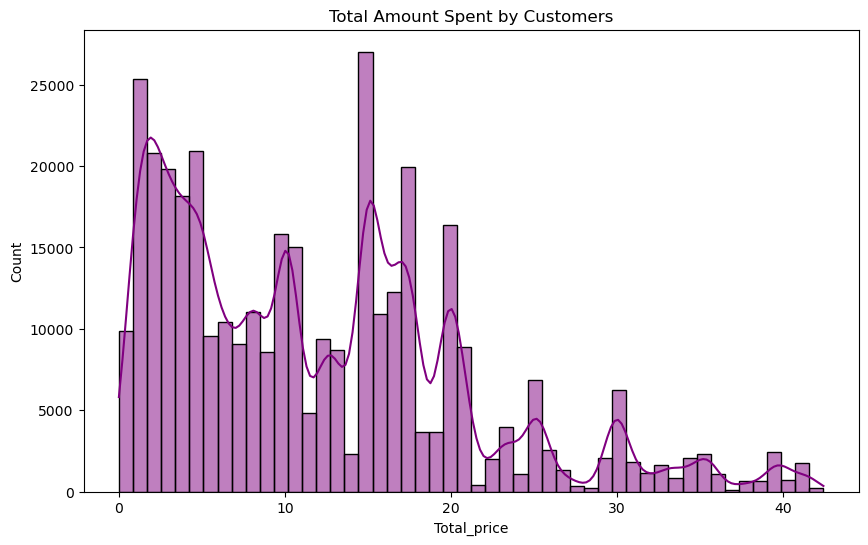

In [53]:
#EDA
#distribution of total number
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(df["Total_price"],bins=50, kde=True,color="purple")
plt.title("Total Amount Spent by Customers")
plt.show()

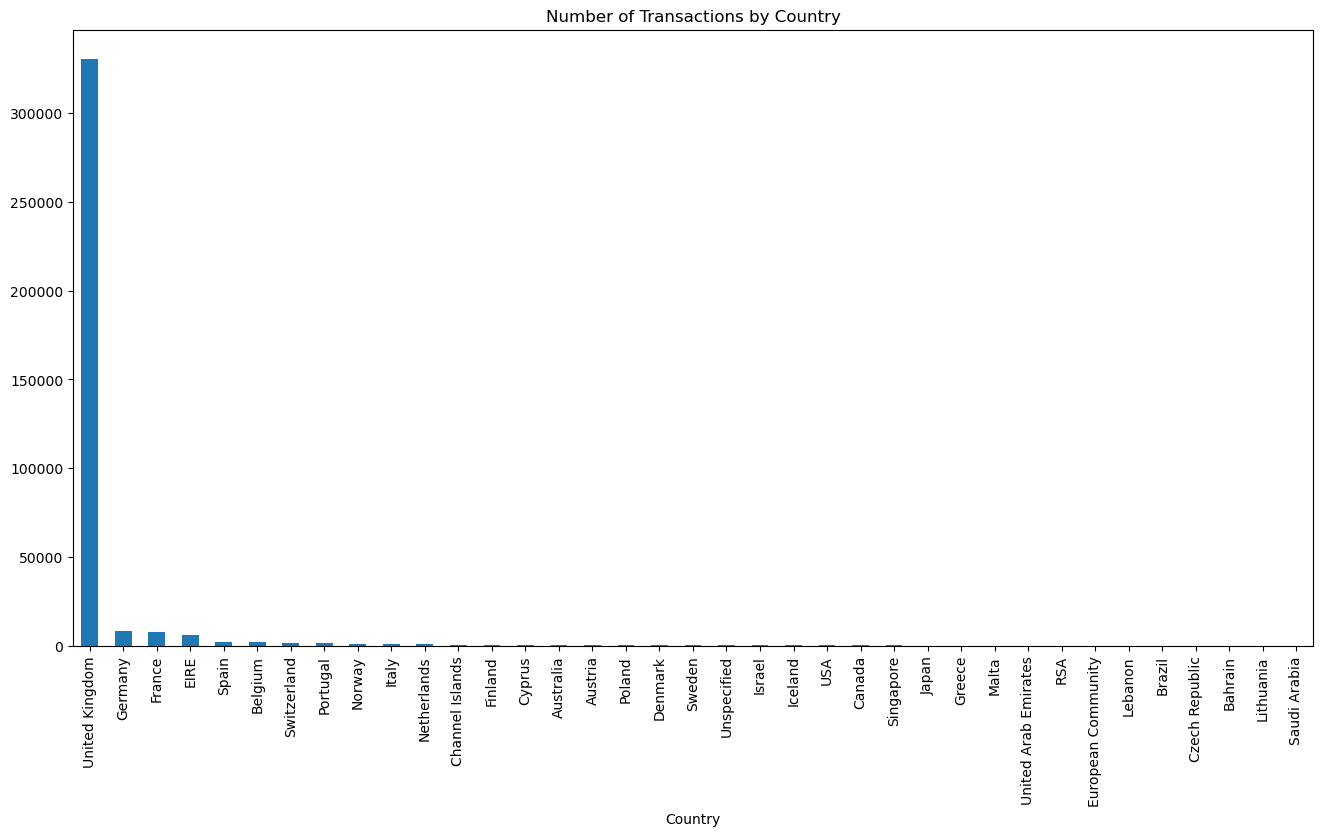

In [61]:
# Distribution of Number of Transactions by Country
plt.figure(figsize=(16,8))
df["Country"].value_counts().plot(kind="bar")
plt.title('Number of Transactions by Country')
plt.show()

In [85]:
#Apply Clustering Algorithms (RFM Segmentation + K-Means) RFM Analysis (Recency, Frequency, Monetary):
#recency:days since last purchase 
df.loc[:,'Recency']=(df['InvoiceDate'].max()-df['InvoiceDate']).dt.days

#frequency:Number of transactions per customer
freq_df=df.groupby('CustomerID').InvoiceNo.nunique()

# Monetary: Total amount spent per customer
money_df=df.groupby('CustomerID').Total_price.sum()

# Combine RFM metrics into a single DataFrame
rfm_df=pd.concat([df.groupby('CustomerID').Recency.min(),freq_df,money_df],axis=1)
rfm_df.columns=['Recency','Frequency','Monetary']

 # Log transformation to reduce skewness
rfm_df['Monetary']=np.log1p(rfm_df['Monetary'])

# Standardize RFM metrics
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
rfm_scaled=sc.fit_transform(rfm_df)

# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=5,random_state=42)
rfm_df['cluster']=kmeans.fit_predict(rfm_scaled)


CustomerID
12347.0    1
12348.0    1
12349.0    1
12350.0    3
12352.0    1
          ..
18280.0    3
18281.0    3
18282.0    4
18283.0    2
18287.0    1
Name: cluster, Length: 4196, dtype: int32

In [93]:
#4. Validate Clustering 
from sklearn.metrics import silhouette_score

#silhouette score
score=silhouette_score(rfm_scaled,rfm_df['cluster'])
print(f'silhouette score:{score}')

# Analyze cluster characteristics
rfm_summary=rfm_df.groupby('cluster').agg({
    'Recency':'mean',
     'Frequency': 'mean',
    'Monetary': 'mean',
    'cluster': 'count'}).rename(columns={'cluster':'CustomerCount'})
print(rfm_summary)


silhouette score:0.38748656844030493
            Recency   Frequency  Monetary  CustomerCount
cluster                                                 
0          1.000000  123.285714  9.945212              7
1         41.652999    4.289474  7.003908           1634
2         14.531609   15.775862  8.220046            348
3        255.810695    1.416043  5.325014            935
4         56.363994    1.674528  5.318445           1272


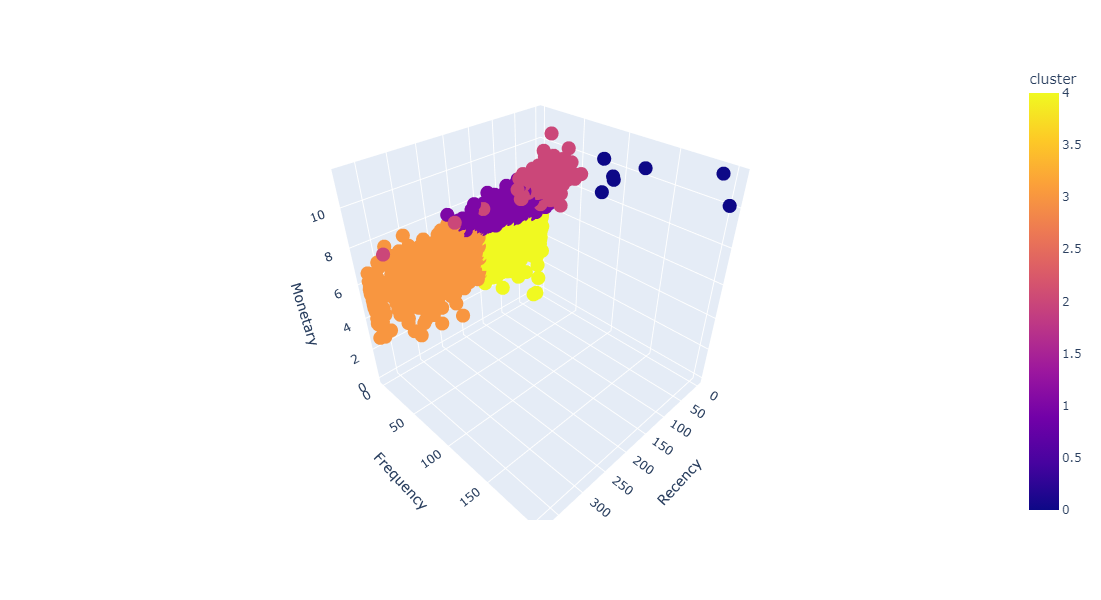

In [133]:
#5. Develop Reports and Dashboards For creating interactive dashboards:
import plotly.express as px

fig=px.scatter_3d(rfm_df,x='Recency',y='Frequency',z='Monetary',width=1000,  # Width of the figure
    height=600,color='cluster')
fig.show()

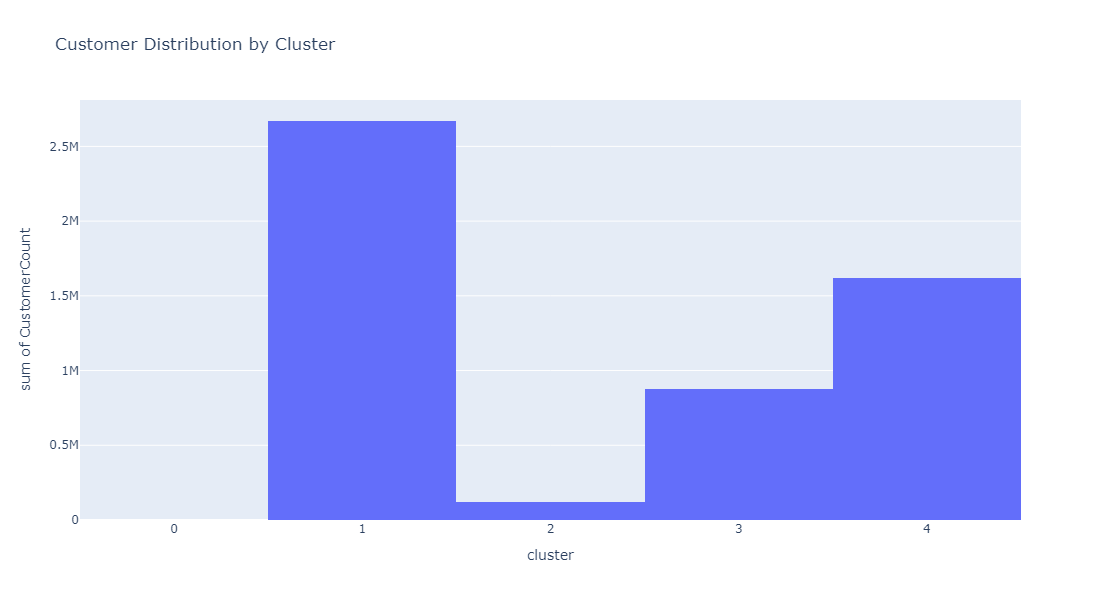

In [129]:
# Add CustomerCount to rfm_df if needed
rfm_df = rfm_df.merge(rfm_summary[['CustomerCount']], left_on='cluster', right_index=True)

fig1=px.histogram(rfm_df,x='cluster',y='CustomerCount',width=1000,  # Width of the figure
    height=600,title="Customer Distribution by Cluster" )
fig1.show()